In [1]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from lesson_functions import extract_features, draw_boxes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

## Possible Car Classifier Class?

In [2]:
vehicles = glob.glob('vehicles/**/*.png', recursive=True)
non_vehicles = glob.glob('non-vehicles/**/*.png', recursive=True)

print("Vehicle Images: ", len(vehicles))
print("Non Vehicle Images: ", len(non_vehicles))

Vehicle Images:  8792
Non Vehicle Images:  8968


In [3]:
# Parameters
color_space = 'RGB'
spatial = 20
hist_bins = 32

# Extract Features
vehicle_features = extract_features(vehicles, color_space=color_space,
                                    spatial_size=(spatial, spatial), hist_bins=hist_bins)
non_vehicle_features = extract_features(non_vehicles, color_space=color_space,
                                        spatial_size=(spatial, spatial), hist_bins=hist_bins)

In [4]:
# Normalize Features
# Create an array stack of feature vectors
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)                        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# X_scaler = StandardScaler().fit_transform(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Prepare Labels Vectors Based on Features
feature_labels = np.hstack((np.ones(len(vehicles)), np.zeros(len(non_vehicles))))

print("Length of Features", len(scaled_X))
print("Length of Labels", len(feature_labels))

Length of Features 17760
Length of Labels 17760


In [5]:
# Train Test Split
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, feature_labels, test_size=0.2, random_state=rand_state)

In [6]:
clf = LinearSVC()
clf.fit(X_train, y_train)
print('Training Accuracy of SVC: ', clf.score(X_test, y_test))

Training Accuracy of SVC:  0.967623873874


## Introduce Sliding Windows

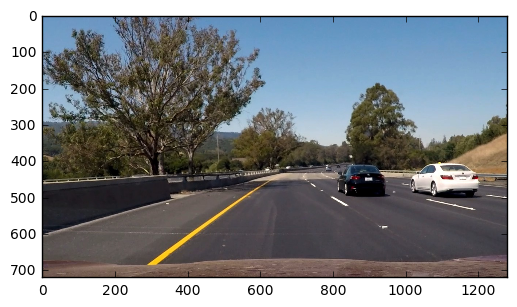

In [7]:
image = mpimg.imread('../test_images/test6.jpg')
plt.imshow(image)
plt.show()

In [8]:
from lesson_functions import slide_window, search_windows

In [9]:
window_sizes = [
    96
]
y_start_stop = [
    [400, 656]
]

windows = []

for i in range(len(window_sizes)):
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop[i], 
                            xy_window=(window_sizes[i], window_sizes[i]), xy_overlap=(0.8, 0.8))

print('Length of Windows: ', len(windows))

Length of Windows:  567


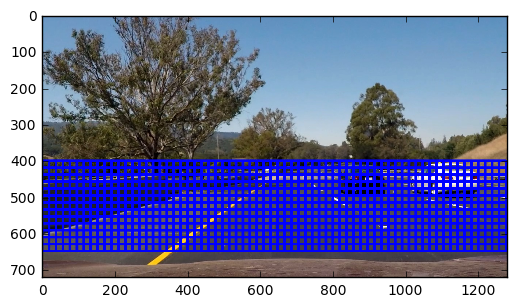

In [10]:
area = draw_boxes(image, windows)
plt.imshow(area)
plt.show()
plt.imsave('../output_images/sliding_windows_test_image.jpg', area, cmap="gray")

In [11]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [12]:
box_list = search_windows(image, windows, clf, X_scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True)

ValueError: operands could not be broadcast together with shapes (1,4932) (3060,) (1,4932) 

In [ ]:
hot_img = draw_boxes(image, box_list)